# Feature Engineering

In this notebook it will be disscussed the algorithms and techniques implemented to extract the features of the audio that we will use as input for our customs models. Specifically, we will work on the following features:

1. Frequency spectograms
2. Mel-spectograms
3. MFCCs

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import IPython.display as ipd

#core libraries
import tensorflow as tf
# Math
import numpy as np


# 1. Reading the audio files

The first step in the input pipeline is to read and load the audio files. Mostly, we will use TensorFlow functions to manipulate and apply any transformation to the data, as most of them are implemented with TPU/GPU-compatible ops and supports gradients.

In [9]:
data_path = 'data/raw_data'
# Choose one audio clip to work with
bed_audio = os.path.join(data_path, 'bed', '00176480_nohash_0.wav')


In [10]:
#readind the audio file...
raw_audio = tf.io.read_file(bed_audio)
# Let's check what we've got
print(f'raw_audio {type(raw_audio)}')   
print(f'raw_audio {raw_audio.numpy()[:20]}') # Print the head(20) of the raw audio

raw_audio <class 'tensorflow.python.framework.ops.EagerTensor'>
raw_audio b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00'


Two things to take from this:
 - raw_audio is indeed a TensorFlow Tensor, any further function or transformation will be handled as a Tensor's operation
 - raw_audio data is a binary file, so we need to decode it

In [11]:
# Decoding...
# We will use another handy tf function: audio.decode_wav...
# https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav

# All audio files were recorded at 16000 samples / seconds
sample_rate = 16000	
audio, sample_rate = tf.audio.decode_wav(raw_audio,
                                         desired_channels=1,  # mono
                                         desired_samples=sample_rate )
                                         
print(f'audio {type(audio)}')   
print(f'audio {audio.shape}') 
print(f'audio {audio.numpy()[:10]}') # Print the head(10) of the decoded audio

audio <class 'tensorflow.python.framework.ops.EagerTensor'>
audio (16000, 1)
audio [[ 9.1552734e-05]
 [ 3.0517578e-05]
 [ 1.8310547e-04]
 [ 1.8310547e-04]
 [-3.0517578e-05]
 [ 3.0517578e-05]
 [ 2.4414062e-04]
 [ 9.1552734e-05]
 [-9.1552734e-05]
 [-6.1035156e-05]]


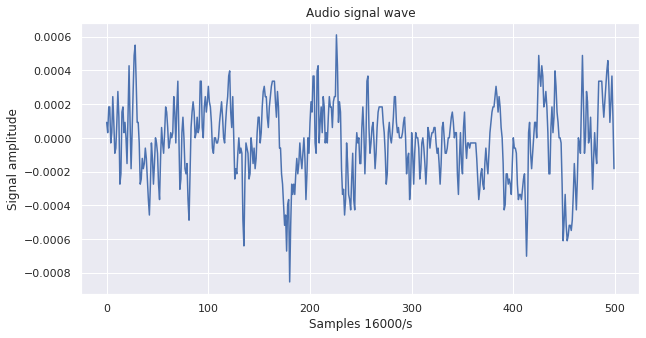

In [15]:
# Let's plot the audio signal wave (just the 500 first samples)
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(audio.numpy()[:500])
plt.title('Audio signal wave')
plt.xlabel('Samples 16000/s')
plt.ylabel('Signal amplitude')
plt.show()

# Spectograms

A Spectogram is a visual representation of the energy contained in  a range of frequencies of audio signals over time.

To obtain the spectogram we used the function “tf.signal.stft” from the signal processing methods included in TensorFlow. More information can be found at https://www.tensorflow.org/api_docs/python/tf/signal/stft


In [13]:

# tf.signal.stft()
# https://www.tensorflow.org/api_docs/python/tf/signal/stft

def audio_to_spectogram(audio):
    """Returns the spectrogram of an audio signal"""
    stfts = tf.signal.stft(audio,
                           frame_length=480,
                           frame_step=160,
                           fft_length=None,
                           window_fn=tf.signal.hann_window,
                           pad_end=False,
                           name=None)
    spectrogram = tf.abs(stfts)           
    return spectrogram

In [16]:
audio = tf.squeeze(audio)
spectrogram = audio_to_spectogram(audio)
print(f'audio {type(spectrogram)}')   
print(f'audio {spectrogram.shape}') 
print(f'audio {spectrogram.numpy()[1,:10]}') # Print the head(10) of the decoded audio

audio <class 'tensorflow.python.framework.ops.EagerTensor'>
audio (98, 257)
audio [0.00973656 0.00881785 0.00641588 0.00282342 0.00108673 0.00126398
 0.00296975 0.00814621 0.00955481 0.01653905]


The following image shows an example of one spectogram generated from the audio, the “y” axis represents the frequencies, which range from 0 to 8000 Hz, and the “x” axis is time (1 second), the brighter the point, the higher is the energy on that frequency at that specific moment.

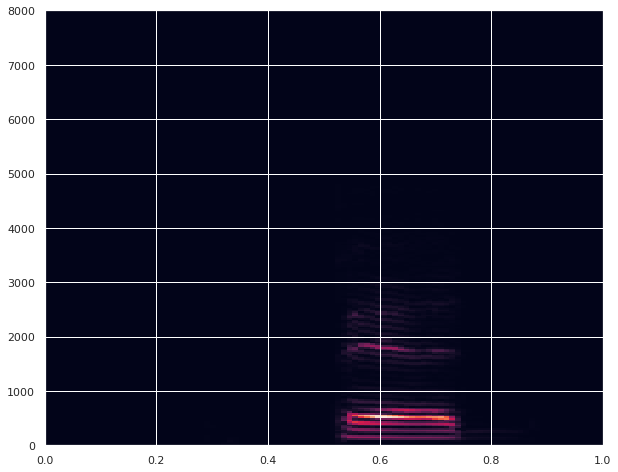

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(tf.transpose(spectrogram), aspect='auto', origin='lower', 
          extent=[0, 1, 0, 8000])

In [20]:
def audio_to_melspectogram(audio):
    """Returns the Mel-spectrogram of an audio signal"""
    stfts = tf.signal.stft(audio,
                           frame_length=480,
                           frame_step=160,
                           fft_length=None,
                           window_fn=tf.signal.hann_window,
                           pad_end=False,
                           name=None)
    spectrograms = tf.abs(stfts)
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    #print(num_spectrogram_bins)
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, 
        num_spectrogram_bins, sample_rate, lower_edge_hertz,upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    return log_mel_spectrograms

In [21]:
log_mel_spectrograms = audio_to_melspectogram(audio)
print(f'audio {type(log_mel_spectrograms)}')   
print(f'audio {log_mel_spectrograms.shape}') 
print(f'audio {log_mel_spectrograms.numpy()[1,:10]}')

audio <class 'tensorflow.python.framework.ops.EagerTensor'>
audio (98, 80)
audio [-6.3330717 -6.9055886 -6.889142  -6.2338786 -5.4149776 -4.9189053
 -4.6586375 -4.176939  -4.125819  -4.442311 ]


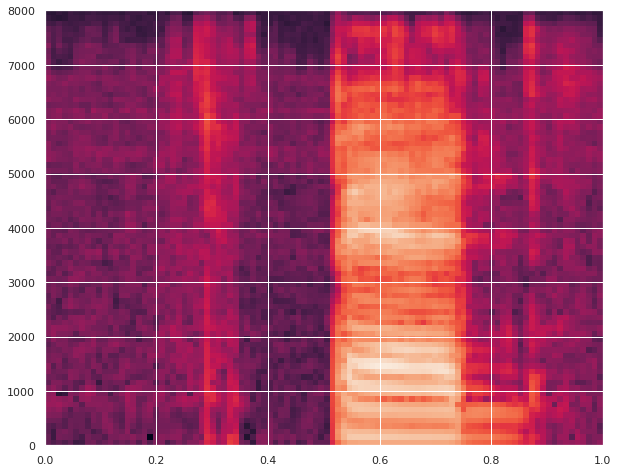

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(tf.transpose(log_mel_spectrograms), aspect='auto', origin='lower', 
          extent=[0, 1, 0, 8000])

In [23]:
# Compute MFCCs from log_mel_spectrograms and take the first |3.
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
print(f'audio {type(mfccs)}')   
print(f'audio {mfccs.shape}') 
print(f'audio {mfccs.numpy()[1,:10]}')


audio <class 'tensorflow.python.framework.ops.EagerTensor'>
audio (98, 13)
audio [-68.31972      1.5253001   -1.8285749    1.9853717   -3.3118446
   0.39122742  -1.8023661   -0.8428184   -0.52806634  -1.440331  ]


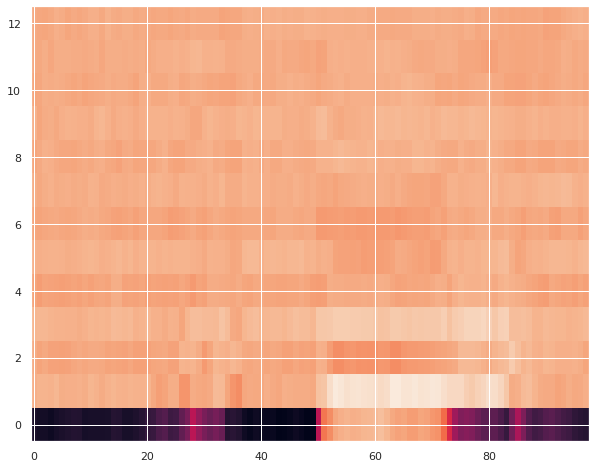

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(tf.transpose(mfccs), aspect='auto', origin='lower')